<a href="https://colab.research.google.com/github/ArmaanSinghSandhu/YOLOv7-Braking-Detection/blob/main/Dataset_Prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dataset Preprocessing and Preperation**

This file is a part of my project to train YOLOv7 on a custom dataset to detect vehicle braking light status for preemptive braking in Autonomous Vehicles/ADAS.

This file only contains the code used for and details the steps undertaken for automated structuring, preprocessing, augmentation and splitting of the dataset for this project. The main file detailing the training and testing is the [YOLOv7_Braking_Detection.ipynb](https://colab.research.google.com/drive/1uxMoyABEvXf6MOd2j0zMawT4u_xrbEKz?usp=sharing) file. 

The code listed below in this file was used to carry out the following steps:

1. Create directory structure to temporarily store the source images, the merged images and the label files and then to store the final split dataset ready for training.

2. Merge the foreground and background images in random combinations while ensuring class equality and also generating bounding box labels in the YOLO format.

3. Split the generated images and labels randomly into training, validation and testing sets while ensuring class equaity in each set. The split dataset are then copied into their corresponding folders.

4. Generate a custom.yaml file containing dataset paths, number of object classes and object class names. Then save the file to the yolov7's 'data' folder.

The details of each step and their execution is given below the code listing.



In [ ]:
import cv2
from PIL import Image
import numpy as np
import os
import random
import shutil
from glob import glob
from tqdm import tqdm
 
# This is my directory structure and the following code is designed according to it. You might need to change the code according to your setup.

# yolov7                        (Root of the YOLOv7 repository. This is where all the code will be executed from.)
# +-----data_source             (Folder containing all the background and foreground source images)
#       +----------Braking      (Folder containing the cropped images of all the cars with brake lights on)
#       +----------Normal       (Folder containing the cropped images of all the cars with brake lights off)
#       +----------Backgrounds  (Folder containing all the background image files)
#       +----------MergedImages (Folder containing the images of merged foreground with background)
#       +----------Labels       (Labels for the merged images)
# +-----dataset                 (Folder containing the training, validation & test data along with the labels)
#       +------train
#              +----images
#              +----labels
#       +------valid
#              +----images
#              +----labels
#       +------test
#              +----images
#              +----labels

# You can replace the following paths as per your setup and requirements
cur_dir = os.curdir                                                         # The YOLOv7 repository root directory

data_src_path = os.path.join(cur_dir, 'data_source')                        # Path to the folder which will countain the source foreground and background images
dataset_path = os.path.join(cur_dir, 'dataset')                             # Path to the folder which will contain the final merged images and their labels
dest_img_dir = os.path.join(data_src_path, 'MergedImages')                  # Path to the folder where the final merged images will be stored
label_dir = os.path.join(data_src_path, "Labels")                           # Path to the folder where the label files will be stored
dataset_folders = ['train', 'valid', 'test']                                # List of folders to be created inside the 'dataset' folder 

obj_classes = ['Normal', 'Braking']                                         # List of object classes in the dataset

# A function to create the directory structure as listed above
def create_dirs():
  os.mkdir(data_src_path)                                                         # Create 'data_source' folder
  os.mkdir(dataset_path)                                                          # Create 'dataset' folder
  data_src_folders = obj_classes + ['Backgrounds', 'MergedImages', 'Labels' ]     # List of folders to be created inside the 'data_source' folder 
  for folder_name in data_src_folders:                                            # Create the folders from the list inside the 'data_source' folder
    os.mkdir(os.path.join(data_src_path, folder_name))                            
  for folder_name in dataset_folders:                                             # Create folders from the list inside the 'dataset' folder and inside each folder..
    folder_path = os.path.join(dataset_path, folder_name)                         
    os.mkdir(folder_path)
    os.mkdir(os.path.join(folder_path, 'images'))                                 # create the folders named 'images'
    os.mkdir(os.path.join(folder_path, "labels"))                                 # and 'labels'
  print('Directory structure created for dataset')







 # A function to square the background image received as a numpy array 
 # by extracting the square center of the image, cropping the extra width
 # equally from both sides. Assumes width larger than height.
def square_img(img):

  h, w, c = img.shape                                                 # Get the image dimensions
  diff = w - h                                                        # Calculate the extra width
  
  if diff >= 0:                                                       # If the image has greater width than height
    x1 = int(diff/2)                                                  # ROI begins horizontally leaving half of the extra width on the left
    y1 = 0                                                            # Begins vertically from the top
    x2 = x1 + h                                                       # Make ROI width equal to the image height
    y2 = h                                                            # and height also equal to image height 
    crop = img[y1:y2, x1:x2]                                          # Extract the square center of the image
  
  else:                                                               # If the image has greater height than width
    diff = -diff                                                      # Changing diff back to positive
    y1 = int(diff/2)                                                  # ROI begins vertically leaving half of extra height on the top
    x1 = 0                                                            # Begins horizontally from the left
    y2 = y1 + w                                                       # Make ROI height equal to image width
    x2 = w                                                            # The width is also equal to the image width
    crop = img[y1:y2, x1,x2]                                          # Extract the square center of the image

  return crop                                                         # Return the extracted image



# A function to convert an image in OpenCV image format (numpy array) to Pillow image format
def convert2PIL(img):

  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)                          # Convert the OpenCV image color order from BGR to RGB 
  im_pil = Image.fromarray(img)                                       # Convert the numpy array to pillow image

  return im_pil                                                       # Return the converted image



# A function to convert an image in Pillow image format to a numpy arrat
def convert2cv(img):

  img = np.array(img)                                                 # Convert image to numpy array
  cv_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)                       # Convert the color order from RGB to BGR

  return cv_img                                                       # Return the converted image



# A function which takes a background image and a foreground image as input
# and returns the ideal position of the foreground image in the background image 
# and the text for the YOLO label file with bounding box coordinates and dimensions.
# All the margins, multiplication factors and steps will need to be tweaked and ajusted according to the dataset images to get optimal results.
def get_img_pos(src, dest):

  src_h, src_w, c = src.shape                                         # Get the foreground (source) image dimensions
  dest_h, dest_w, c = dest.shape                                      # Get the background (destination) image dimensions
  bottom_margin = 20                                                  # Set a margin for the foreground image y axis up from the bottom of the background image

  max_src_y = (dest_h - src_h) - bottom_margin                        # The y coordinate of the foreground image should be high enough so that the image bottom 
                                                                      # touches the bottom margin

  adjustment_factor = 1.5                                             # This value will need to be tweaked to adjust the foreground image placement height 
                                                                      # according to it's dimensions for the depth perception
  
  y_offset = round((100 - ((src_h/dest_h) * 100)) * adjustment_factor)  # Calculate a y axis offset so that the smaller images are placed higher while the 
                                                                      # Larger ones are placed lower to achieve a depth perception as in the real world

  src_y = max_src_y - y_offset                                        # Make sure the foreground image stays higher than the bottom margin
  y_rand_factor = 5                                                   # Set a small factor by which to randomly vary the vertical placement of foreground image
  y_rand_steps = 1                                                    # Randomness incrementation step
  src_y = random.randrange(src_y - y_rand_factor, src_y + y_rand_factor, y_rand_steps)   # Randomly vary the y coordinate of the foreground image by a small factor

  side_margin = 50                                                    # Set a margin for the foreground image x axis from both sides of the background image
  min_src_x = side_margin                                             # Set the left bound for foreground image x axis leaving the side margin
  diff_w = dest_w - src_w                                             # Get the width difference between both the images
  max_src_x = diff_w - side_margin                                    # Set the right bound so that the foreground image's right side does not cross the side margin
  
  if max_src_x <= min_src_x:                                          # If the source image width is greater than the area between the margins
    max_src_x= min_src_x + 10
  
  x_rand_steps =  1                                                   # Randomness incrementation step
  src_x = random.randrange(min_src_x, max_src_x, x_rand_steps)        # Randomly vary the x coordinate of the foreground image

  # Following steps calculate the bounding box coordinates and dimensions for the YOLO label file
  # which are the coordinates and dimensions of the foreground image relative to the backgound image.
  # YOLO label records the bounding box center coordinates divided by the background image's width and height.
  # Bounding box height and width are also divided by background image's width and height for the label file.
  src_mid_x = src_x + round(src_w/2)                                  # Calculate the center x coordinate of the source image relative to the background image
  src_mid_y = src_y + round(src_h/2)                                  # Calculate the center y coordinate of the source image relative to the background image
  label_x = round(src_mid_x/dest_w, 7)                                # Convert the center x coordinate to YOLO label format by dividing it by background image width
  label_y = round(src_mid_y/dest_h, 7)                                # Convert the center y coordinate to YOLO label format by dividing it by background image height
  label_w = round(src_w/dest_w, 7)                                    # Convert the bounding box width to YOLO label format by dividing it by background image width
  label_h = round(src_h/dest_h, 7)                                    # Convert the bounding box height to YOLO label format by dividing it by background image height

  # Create the string for YOLO label file by combining the bounding box coordinates and dimensions calculated above
  label_txt = str(label_x) + " " + str(label_y) + " " + str(label_w)+ " " + str(label_h)

  return src_x, src_y, label_txt                                      # Return the coordinates of the foreground image along with the text for the label file


# A function that overlays a foreground image on a background image receiving both the images as numpy array input
def insert_img(src, dest):

  dest_cpy = dest.copy()                                              # Create a copy of the background image if you want to preserve the original
  src_x, src_y, label_txt = get_img_pos(src, dest)                    # Get the coordinates for placing the foreground image in the background image
                                                                      # Along with the YOLO label text
  src_pil = convert2PIL(src)                                          # Convert foreground image to pillow image
  dest_pil = convert2PIL(dest_cpy)                                    # Convert background image to pillow image
  Image.Image.paste(dest_pil, src_pil, (src_x, src_y))                # Overlay the foreground image on the background
  merged = convert2cv(dest_pil)                                       # Convert the merged image back to opencv format

  return merged, label_txt                                            # Return the merged image along with YOLO label text

# A function that randomly combines the foreground images with the background images to generate a dataset of a given number of images and labels
def create_dataset():

  imgs_per_cls = 2000                                                 # Number of merged ouput images you want to generate per class
  
  bg_dir = os.path.join(data_src_path, "Backgrounds")                 # Path to the folder containing background images
  if not os.path.exists(bg_dir):                                      # Checking if the folder exists.
    raise Exception("Backgrounds folder not found. Please check your directory structure.")
  bg_imgs_lst = os.listdir(bg_dir)                                    # List of images in the 'Backgrounds' folder
  num_bg_imgs = len(bg_imgs_lst)                                      # Number of images in the 'Backgrounds' folder
  if num_bg_imgs == 0:
    raise Exception("No images found in Backgrounds folder. Please check your folder")

  cls_id = 0                                                          # Current object class in the list of classes

  for obj_class in obj_classes:                                       # Iterate through the list of classes
    fg_dir = os.path.join(data_src_path, obj_class)                   # Get the path to the folder containing source/foreground images for the current object class
    if not os.path.exists(fg_dir):                                    # Check if the folder is accessible
      raise Exception("Folder for " + str(obj_class) + " not found. Please check your directory structure.")
    fg_imgs_lst = os.listdir(fg_dir)                                  # List of images in the foreground image folder of the current object class
    num_fg_imgs = len(os.listdir(fg_dir))                             # Number of images in the foreground image folder of the current object class
    if num_fg_imgs == 0:                                              # Check if the folder has images
      raise Exception("No images found in " + str(obj_class) + " folder. Please check your folder")

    for n in tqdm(range(0, imgs_per_cls)):                            # Loop through the number of output files you want to generate per class
      r_fg = random.randrange(0, num_fg_imgs - 1, 1)                  # Randomly generate a numer to select a foreground image
      r_bg = random.randrange(0, num_bg_imgs - 1, 1)                  # Randomly generate a numer to select a background image
      
      fg_img_file = os.path.join(fg_dir, fg_imgs_lst[r_fg])           # Get the path to the random foreground image file
      bg_img_file = os.path.join(bg_dir, bg_imgs_lst[r_bg])           # Get the path to the random background image file
      
      fg_img = cv2.imread(fg_img_file)                                # Read the foreground image from file
      bg_img = cv2.imread(bg_img_file)                                # Read the background image from file
      
      if fg_img.size == 0:                                            # Checking if the file can be read. If not, raise exception
        raise Exception("Foreground Image file can not be accessed. Check file named: " + str(fg_imgs_lst[r_fg]))
      if bg_img.size == 0:                                            # Checking if the file can be read. If not, raise exception
        raise Exception("Background Image file can not be accessed. Check file named: " + str(bg_imgs_lst[r_bg]))
      
      bg_img = square_img(bg_img)                                     # Square the background image
      
      out_img, lbl_txt = insert_img(fg_img, bg_img)                   # Get the merged output image and the text for the label file
      out_file = os.path.join(dest_img_dir, obj_class + "-" + str(n) + ".jpg")  # Create the path and filename for the merged ouput image file
      cv2.imwrite(out_file, out_img)                                  # Write the output image file
      
      lbl_txt = str(cls_id) + " " + lbl_txt                           # Add object class id to the beginning of the label string
      lbl_file = os.path.join(label_dir, obj_class + "-" + str(n) + ".txt") # Create the path and filename for the label file
      with open(lbl_file, "w") as f:                                  # Write the complete label string to the label file  
        f.write(lbl_txt)

  cls_id = cls_id + 1                                                 # Increment the curremt object class counter

# A function that splits the generated dataset from create_dataset() into the training, validation and testing sets.
# The data is split according to the split ratio defined in the split_ratio array. The files are randomly chosen while ensuring class equality
def split_dataset():
  split_ratio = [0.80, 0.10, 0.10]                                    # Set the ratio in which to split the images and labels into the training, validation and test sets  
  if sum(split_ratio) == 1:                                           # Continue if the sum of all the ratios is 100%
    for obj_class in obj_classes:                                     # Iterate through the object classes
      imgs_filter = obj_class + '*.*'                                 # Create a filter to select images and labels with name begining with the name of the current object class
      imgs_path = os.path.join(dest_img_dir, imgs_filter)             # Add the path to the merged images folder to the filter 
      file_lst = glob(imgs_path)                                      # Get the list of image files belonging to the current object_class
      num_files = len(file_lst)                                       # Get the number of files in the list
      if num_files == 0:                                              # Check if any images found in directory
        raise Exception("Unable to split dataset. No images found in the " + str(dest_img_dir) + " directory")
      
      random.shuffle(file_lst)                                        # Shuffle the list
      
      i = 0                                                           # Counter to loop through the ratios
      n = 0                                                           # Counter to the number of files copied per class
      
      max_files = split_ratio[i] * num_files                          # Calculate the max number of files that can be copied according to the current ratio
      
      for img_file in tqdm(file_lst):                                 # Iterate through the file list
        if n == max_files:                                            # Check if the number of files copied is equal to the max allowed under current ratio
          i = i + 1                                                   # Increment the counter to the next ratio
          max_files = max_files + (split_ratio[i] * num_files)        # Increase the max number of files allowed by those allowed under the current ratio
        
        fname = os.path.basename(img_file)                            # Extract the image file name from the full file path
        
        lbl_fname = fname.split('.')[0] + '.txt'                      # Extract the file name without the extension and append '.txt' extension to it
        lbl_file = os.path.join(label_dir, lbl_fname)                 # Join the path to the folder containing the labels to the text file name
        
        dest_split_dir = os.path.join(dataset_path, dataset_folders[i]) # Use the i counter to get the name of the current destination dataset folder (train, valid or test) and its path
        dest_split_imgdir = os.path.join(dest_split_dir, 'images')    # Get the path to the 'images' folder inside the destination folder
        dest_split_lbldir = os.path.join(dest_split_dir, 'labels')    # Get the path to the 'labels' folder inside the destination folder
        
        shutil.copy(img_file, dest_split_imgdir)                      # Copy the current image file to the destination 'images' folder
        shutil.copy(lbl_file, dest_split_lbldir)                      # Copy the current label file to the destination 'labels' folder
        
        n = n + 1                                                     # Increment the files copied counter
  
  else:                                                               # Raise an exception if the file ratios do not add up to 1.00 or 100%
    raise Exception("Invalid file distribution ratios. Please check your split ratios.")

        
#Create the yaml file in the 'data' folder containing dataset paths along with object class details
def create_yaml():
  yaml_name = 'custom.yaml'
  file_data = ''

  for folder in dataset_folders:
    tag = folder
    if folder == 'valid':
      tag = 'val'
    file_data = file_data + tag + ": " + os.path.join(dataset_path, folder) + '\n'

  file_data = file_data + '\n'
  file_data = file_data  + 'nc: ' + str(len(obj_classes)) + '\n\n' 
  file_data = file_data + 'names: ' + str(obj_classes)

  yaml_path = os.path.join(os.curdir, 'data')
  yaml_file = os.path.join(yaml_path, yaml_name)

  with open(yaml_file, 'w') as f:
    f.write(file_data)

  print('File generated successfully')



#1. Create the following directory structure inside the yolov7 folder

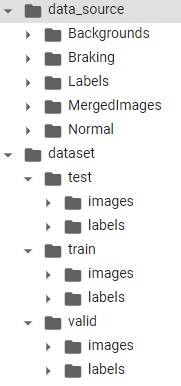

The "create_dirs()" command executed below creates the above directory structure inside the yolov7 folder. The 'data_source' folder will contain the images of the vehicles separated into folders according to each class along with a folder for the background images. The merged images and their generated labels will be stored in their respective folders under the 'data_source' folder. The split_dataset() command will copy the merged images and labels as per the predefined split ratios randomly (while maintaining class equality) into the 'train', 'valid' and 'test' folders under the 'dataset' folder. Path variables in the code can be modified to incorporate a different directory structure.

In [ ]:
create_dirs()

Directory structure created for dataset


# 2. Manual downloading, sorting, selection and uploading images to their respective folders in the data_source folder

After downloading the images, they were manually sifted through. The vehicle images were filtered on the basis of vehicle diversity, sizes, angles, lighting, resolution and duplicates. It was ensured that there were equal number of images for each detection class. While the backgrounds were filtered on the basis of lighting, diversity, shots of long & open roads/highways, minimal to no leading traffic. The vehicle images were then sorted into two main categories: 

1. All images with braking lights on (Braking, Braking & Turning Right, Braking & Turning Left) were combined under the 'Braking' category. 

2. All images with braking lights off (All lights off, Turning Left, Turning Right) were combined under the 'Normal' category.

The selected images were then uploaded to their repective folders as follows:

Images of braking vehicles -> data_source/Braking

Images of non braking vehicles -> data_source/Normal

Background images -> data_source/Backgrounds

#3. Merge the vehicle images with the backgrounds

The "create_dataset()" command executed below merges vehicle images with the background images and generates bounding box labels for the vehicles in the YOLO format.
Keeping the number of images from each class equal, the vehicle images and background images are randomly selected and merged. Before merging, the background images are squared for YOLO training input optimization. The foreground image is then positioned vertically on the background according to the foreground image size to achieve a depth effect as in the real world. While the horizontal position is randomly selected. Levels of margins, adjustment factors and randomization can be tweaked for optimal results. A '.txt' bounding box label file in the YOLO format, bearing the same name as the image file is generated from the position of the foreground image in the background image. The merged image is saved in the 'data_source/MergedImages' folder while the labels are saved in the 'data_Source/Labels' folder.

In [ ]:
create_dataset()

100%|██████████| 2000/2000 [02:25<00:00, 13.79it/s]


# 4. Split the generated images and labels into training, validation and testing sets

The "split_dataset" command executed below splits the merged images and labels randomly according to a split ratio preset in the beginning of the function definition while ensuring the class equailty in each split. The split data is copied into their respective folders in the 'dataset' folder.

In [ ]:
split_dataset()

100%|██████████| 2000/2000 [00:50<00:00, 39.23it/s]


# 5. Generate the yaml file containing the dataset paths along with the class details

The "create_yaml()" command executed below generates a .yaml file containing the paths to the dataset training, validation and testing folders along with the total number of classes and class names. The file is saved in the 'data' folder inside the yolov7 folder.

In [ ]:
create_yaml()

File generated successfully


# Preprocessing complete

The data preprocessing has now been completed and the yaml file has been generated. The dataset and the yaml file can now be used to train the YOLOv7 model, the details of which can be found in the main project file at [YOLOv7_Braking_Detection.ipynb](https://colab.research.google.com/drive/1uxMoyABEvXf6MOd2j0zMawT4u_xrbEKz?usp=sharing).